In [1]:
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
# from labellines import labelLines

In [2]:
p_c = Symbol("p_c")
h = Symbol("h")
theta = Symbol("theta")
theta = 45/180*pi 
beta = Symbol("beta")
beta = 0

In [3]:
r_e = Symbol("r_e") #[m] nozzle radius exit

In [4]:
g = 1.62 # gravitational constant

#Set exhast gas parameters (fuel mixture estimate)
R = 8.314/0.028 #[J/mol·K] universal gas constant, normalized by molar mass
gamma = 1.26 # heat capacity ratio
mu_c = 17.49E-6 #[Pa.s] #viscosity in the rocket chamber

M_e = 5 #nozzle exit mach number
T_c = 3400 #[K] #temperature in the rocket chamber
#Configure the surface geology parameters
D = (109) *1e-6 #diameter of dust particles (microns)
c = 0.6 #packing concentration in dust layer
sigma = 2500 #[kg/m3]density of dust particle

A_coh = 0 #cohesional shear stress (experimental)
tau_coh = 0 #cohesional shear stress (experimental)
alpha = (20)*pi/180 #static angle of repose of cohensionless particles (deg)
alpha_collapse = (25)*pi/180 #angle of repose at which avalanche start (deg)

K = 1 # shear stress augmentation factor

In [5]:
k = gamma*(gamma-1)*M_e**2 #hypersonic simularity parameter
p_r = p_c*(1+gamma*M_e**2)/(1+(gamma-1)/2*M_e**2)**(gamma/(gamma-1)) #post-shock recovery pressure without inverse-square propagation
# p_s = minimum(p_r,(k+2)/2*(r_e/h)**2*p_r) #post-shock centerline pressure with inverse-square propagation
p_s = (k+2)/2*(r_e/h)**2*p_r
p = p_s*cos(theta)**(k+4)*cos(beta)**2*(1-tan(theta)*tan(beta))**2 #ground pressure
u = sqrt(2*gamma/(gamma-1)*R*T_c*(1-(p/p_s)**((gamma-1)/gamma))) #velocity parallel to surface
q = (gamma/(gamma-1))*(1-(p/p_s)**((gamma-1)/gamma))*(p/p_s)**(1/gamma)*p_s #dynamic pressure
rho = 2*q/(u**2) #density
mu = mu_c*(p/p_s)**((gamma-1)/(2*gamma)) #gas viscosity

#Reynolds Numbers
Re_D = rho*u*D/mu #particle Reynold number
# Re_theta = rho*u*r/mu #surface Reynold number

#Fluid Coefficents
C_d = 24/Re_D #+ 3/Re_D**2 +0.34 #friction coefficient of particles
C_f = 0.84 #friction coefficient of surface

#Calculated derived values continued
tau = K*C_f*q #surface shear
tau_star = sigma*c*D*g*(cos(beta)*tan(alpha) - sin(beta)) + A_coh*D**(-3) + tau_coh #shear retaining stress
Xi = 18*mu_c*h/(sigma*D**2*sqrt(R*T_c*(k+4)))*(1+((k+2)*D*C_d*p_r)/(72*sqrt(2)*mu_c*sqrt(R*T_c))*(r_e/h)**2) #goes inside the momentum factor
a = 1/(0.5 + sqrt( 0.25 + (1/Xi) )) #momentum factor

#Calculate erosion rate
dy_dt = 2*(tau-tau_star)/(a*u*sigma*c*cos(beta)) # erosion rate

In [6]:
dy_dt.expand()

-2.6928276640805e-6*sqrt(0.000755339180869809 + 1/(h + 2.59509137619566*sqrt(2)*h))*tan(pi/9) - 7.40081531642018e-8*tan(pi/9) + 1.25661809151427e-7*p_c*r_e**2*sqrt(0.000755339180869809 + 1/(h + 2.59509137619566*sqrt(2)*h))/h**2 + 3.45361812143486e-9*p_c*r_e**2/h**2

In [7]:
factor(dy_dt, p_c)

(-0.52974*h**2*tan(pi/9) + 0.0247205150436568*p_c*r_e**2)*(5.08330060799731e-6*sqrt(0.000755339180869809 + 0.00196017419437793*sqrt(2) + 1/h) + 1.39706560131766e-7*sqrt(1 + 2.59509137619566*sqrt(2)))/(h**2*sqrt(1 + 2.59509137619566*sqrt(2)))

In [8]:
const_pc = (51634.837*4)*200
const_pc2 = (51634.837*4)*2
N(dy_dt.subs([(h, 10),(p_c, const_pc)]))

0.00915528648061939*r_e**2 - 1.72866270180526e-7

In [9]:
plt.rcParams.update({'font.size': 20, 'font.family' : 'Times New Roman'})
heights = np.linspace(1,1000,10000)
r_e_ac = 1
dummy_heights = heights/(r_e_ac*2)
erosion_rate = []
fig, ax = plt.subplots(figsize=(12,12))
ax.plot()

range1 = np.linspace(5, 29.956, 2) * 6895
# lander = np.array([758423]) # apollo, CE-20
range2 = np.linspace(38.765, 119.523, 4) * 6895
range3 = np.linspace(119.523 * 6895, 6e6, 5)
range_pc = np.sort(np.concatenate((range1, range2, range3)))
# dummy_range = range_pc * (10e-4)
mapofcolors = plt.cm.Wistia_r(np.linspace(0, 0.75, len(range_pc)))[::-1]

for idx, const_pc in enumerate(range_pc):
    erosion_rate = []
    for i in heights:
        erosion_rate_m = float(N(dy_dt.subs([(h, i),(p_c, const_pc), (r_e, r_e_ac)])))
        erosion_rate_yD = erosion_rate_m * (r_e_ac*2)
        erosion_rate.append(erosion_rate_yD)
    color = mapofcolors[idx]
    label_str = ""
    if idx == 5:
        label_str = f"Apollo LDM: {np.round(const_pc*1e-6,3)}MPa"
    elif idx == 10:
        label_str = f"CE-20: {np.round(const_pc*1e-6,3)}MPa"
    else:
        label_str = f"{np.round(const_pc*1e-6,3)}MPa"
    ax.plot(dummy_heights, erosion_rate, label = label_str, color=color)
# labelLines(plt.gca().get_lines(), zorder=2.5)
plt.title('Erosion Rate vs Height for varying Chamber Pressures')
plt.xlabel('Height (h/d)')
plt.ylabel('Erosion Rate ((y/D)/s)')
plt.legend()
# ax.set_ylim(bottom = -, top = 1.0)
# ax.set_xlim(right = 40.0)
plt.xscale('log')
# plt.yscale('log')
plt.grid()

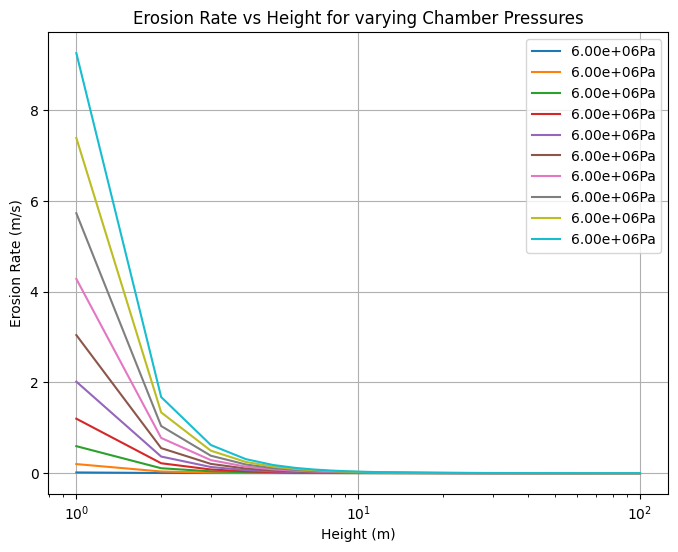

In [ ]:
heights = np.linspace(1,100, 100)
erosion_rate = []
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot()

range1 = np.linspace(5, 29.956, 4) * 6895
range2 = np.linspace(38.765, 110, 4) * 6895
range3 = np.linspace(119.523, 200, 3) * 6895
range_pc = np.concatenate((range1, range2, range3))

range_re = np.linspace(0.2,5,10)

for re in range_re:
    erosion_rate = []
    for i in heights:
        erosion_rate.append(float(N(dy_dt.subs([(h, i),(p_c, const_pc), (r_e, re)]))))
    ax.plot(heights, (erosion_rate), label = (str("{:.2e}".format(const_pc) + 'Pa')))
# labelLines(plt.gca().get_lines(), zorder=2.5)
plt.title('Erosion Rate vs Height for varying Chamber Pressures')
plt.xlabel('Height (m)')
plt.ylabel('Erosion Rate (m/s)')
plt.legend()
# ax.set_ylim(bottom = -, top = 1.0)
# ax.set_xlim(right = 40.0)
plt.xscale('log')
# plt.yscale('log')
plt.grid()